# 02_Train_Baseline.ipynb
### Train a simple CNN baseline on 48×48 grayscale images (FER2013)
This notebook trains the small baseline CNN (quick to run) and saves `models/baseline_cnn.h5`.

In [11]:
# Install required packages (run once)
!pip install tensorflow mtcnn opencv-python matplotlib numpy pandas tqdm scikit-learn --quiet


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

DATA_DIR = '../data/cropped_faces'
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 25
OUT_MODEL = '../models/baseline_cnn.h5'
os.makedirs('../models', exist_ok=True)

In [13]:
# Define baseline CNN
def build_baseline_cnn(input_shape=(48,48,1), num_classes=7):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
# Prepare data generators
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
num_classes = train_gen.num_classes
print('Num classes:', num_classes)

Found 30503 images belonging to 7 classes.
Found 5384 images belonging to 7 classes.
Num classes: 7


In [15]:
# Build, compile and summarize model
model = build_baseline_cnn(input_shape=(48,48,1), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/utsanjan/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,471 (369.03 KB)

 Trainable params: 94,023 (367.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Callbacks
callbacks = [
    ModelCheckpoint(OUT_MODEL, save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss')
]

In [ ]:
# Train (feature extraction)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[TqdmCallback(verbose=1)] + callbacks,
    verbose=0
)

0epoch [00:00, ?epoch/s]/Users/utsanjan/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
100%|██████████| 25/25 [51:10<00:00, 122.84s/epoch, accuracy=0.631, loss=0.991, val_accuracy=0.6, val_loss=1.06]


In [18]:
# Save final model (best already saved by checkpoint)
model.save(OUT_MODEL)
print('Saved model to', OUT_MODEL)

Saved model to ../models/baseline_cnn.h5


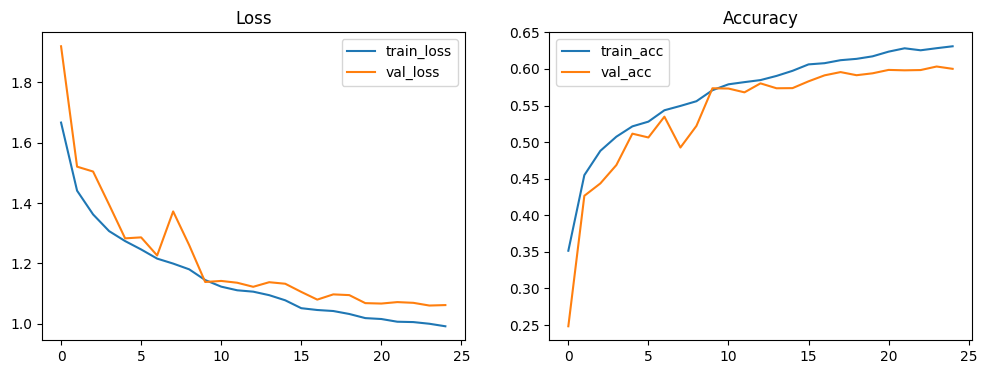

In [19]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [20]:
# Quick evaluation on validation set
val_steps = val_gen.samples // val_gen.batch_size
results = model.evaluate(val_gen, steps=max(1, val_steps))
print('Validation results (loss, acc):', results)

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6000 - loss: 1.0662
Validation results (loss, acc): [1.0609948635101318, 0.6026785969734192]
